# **Cataract Eye Prediction using CNN Model**

### Made by:
* Rendy Ananta Kristanto (M239B4KY3748)
* Ryan Krishandi Lukito (M008B4KY3984)
* Leif Sean Kusumo (M239B4KY2262)
```
Resource: https://www.kaggle.com/datasets/nandanp6/cataract-image-dataset

Resource (My own drive to extract the data): https://drive.google.com/drive/folders/1pvYAlszXocWbbZiW7kigFqJQwHEmxcrz?hl=ID
```

##Data and Resource Preparation

In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = '/content/drive/MyDrive/datasetCapstone'

data_dir_trainval_cataract = os.path.join(DATA_DIR, 'train_validation/cataract')
data_dir_test_cataract = os.path.join(DATA_DIR, 'test/cataract')
data_dir_trainval_normal = os.path.join(DATA_DIR, 'train_validation/normal')
data_dir_test_normal = os.path.join(DATA_DIR, 'test/normal')

print(f"There are {len(os.listdir(data_dir_trainval_cataract)) + len(os.listdir(data_dir_test_cataract))} images of cataract.")
print(f"There are {len(os.listdir(data_dir_trainval_normal)) + len(os.listdir(data_dir_test_normal))} images of normal.")

There are 318 images of cataract.
There are 315 images of normal.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


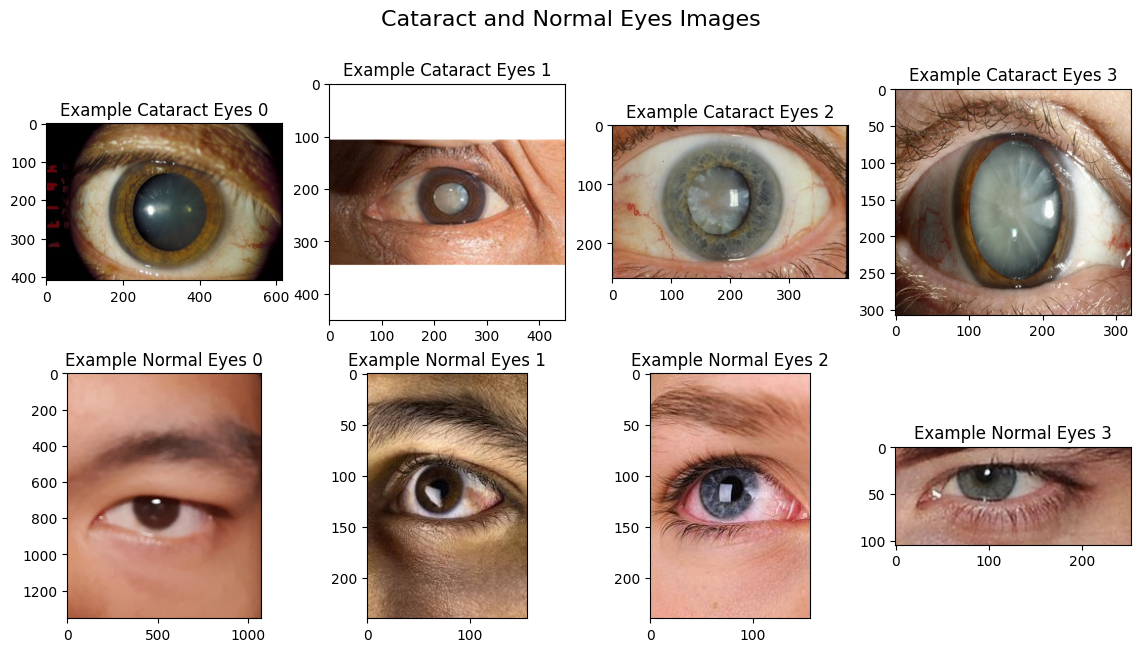

In [ ]:
cats_filenames = [os.path.join(data_dir_trainval_cataract, filename) for filename in os.listdir(data_dir_trainval_cataract)]
dogs_filenames = [os.path.join(data_dir_trainval_normal, filename) for filename in os.listdir(data_dir_trainval_normal)]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Cataract and Normal Eyes Images', fontsize=16)

for i, cat_image in enumerate(cats_filenames[:4]):
    img = tf.keras.utils.load_img(cat_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Cataract Eyes {i}')

for i, dog_image in enumerate(dogs_filenames[:4]):
    img = tf.keras.utils.load_img(dog_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Normal Eyes {i}')

plt.show()

## Training

In [ ]:
def train_val_test_datasets():
    # Training and validation datasets
    training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=os.path.join(DATA_DIR, 'train_validation'),
        image_size=(120, 120),
        batch_size=128,
        label_mode='binary',
        validation_split=0.15,
        subset='both',
        seed=42
    )

    # Test dataset
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=os.path.join(DATA_DIR, 'test'),
        image_size=(120, 120),
        batch_size=128,
        label_mode='binary',
        seed=42
    )

    return training_dataset, validation_dataset, test_dataset


In [ ]:
training_dataset, validation_dataset, test_dataset = train_val_test_datasets()

Found 738 files belonging to 3 classes.
Using 628 files for training.
Using 110 files for validation.
Found 212 files belonging to 3 classes.


In [ ]:
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (128, 120, 120, 3)
Shape of batch of labels: (128, 3)


In [ ]:
def create_augmentation_model():

    FILL_MODE='nearest'
    augmentation_model = tf.keras.Sequential([
		tf.keras.Input(shape=(120,120,3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
    ])

    return augmentation_model

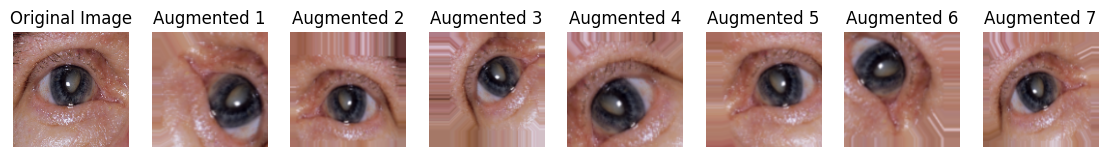

In [ ]:
data_augmentor = create_augmentation_model()

sample_image = tf.keras.utils.array_to_img(example_batch_images[0])

images = [sample_image]

for _ in range(7):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 8, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3', 'Augmented 4', 'Augmented 5', 'Augmented 6', 'Augmented 7']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

In [ ]:
def create_model():

    augmentation_layers = create_augmentation_model()

    model = tf.keras.models.Sequential([
		tf.keras.Input(shape=(120, 120, 3)),
        augmentation_layers,
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model = create_model()

In [ ]:
try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (128, 3)


In [ ]:
def calculate_parameter_count(model):
    total_params = model.count_params()
    print(f'Total number of parameters: {total_params}')
    return total_params
calculate_parameter_count(model)

Total number of parameters: 719587


719587

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 120, 120, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 118, 118, 128)     3584      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 59, 59, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 57, 57, 128)       147584    
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 28, 28, 128)       0         
 ng2D)                                                

In [ ]:
history = model.fit(
	training_dataset,
	epochs=35,
	validation_data=validation_dataset,
)

Epoch 1/35
10/10 [==============================] - 64s 6s/step - loss: 1.1052 - accuracy: 0.3885 - val_loss: 1.1003 - val_accuracy: 0.2273
Epoch 2/35
10/10 [==============================] - 60s 6s/step - loss: 1.0450 - accuracy: 0.4172 - val_loss: 0.9658 - val_accuracy: 0.5000
Epoch 3/35
10/10 [==============================] - 60s 6s/step - loss: 0.9692 - accuracy: 0.5111 - val_loss: 0.8907 - val_accuracy: 0.6000
Epoch 4/35
10/10 [==============================] - 61s 6s/step - loss: 0.8497 - accuracy: 0.5764 - val_loss: 0.7450 - val_accuracy: 0.6455
Epoch 5/35
10/10 [==============================] - 61s 6s/step - loss: 0.7852 - accuracy: 0.5860 - val_loss: 0.9030 - val_accuracy: 0.5364
Epoch 6/35
10/10 [==============================] - 60s 6s/step - loss: 0.7094 - accuracy: 0.6226 - val_loss: 0.7077 - val_accuracy: 0.6000
Epoch 7/35
10/10 [==============================] - 60s 6s/step - loss: 0.7323 - accuracy: 0.6433 - val_loss: 0.7416 - val_accuracy: 0.6273
Epoch 8/35
10/10 [==

KeyboardInterrupt: 

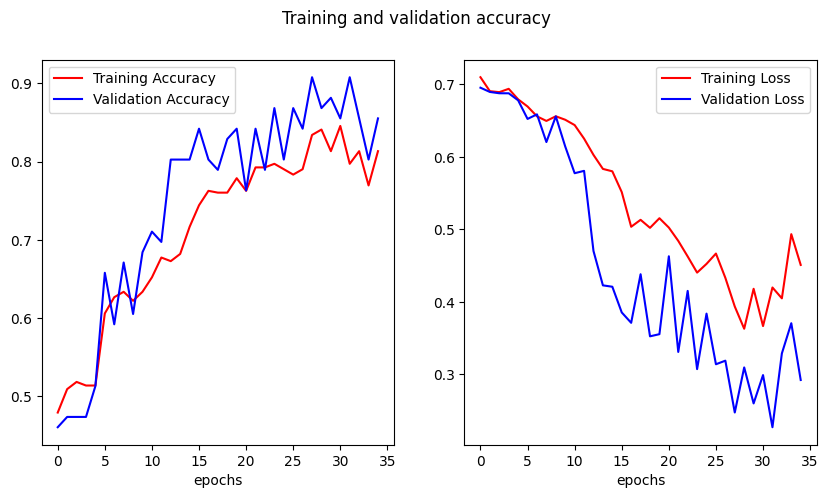

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [ ]:
model = tf.keras.models.load_model("modelnew.h5")

## Testing

In [ ]:
def predict_eye_condition(image_paths, model, threshold=0.5, output_file='prediction_results.txt'):
    results = []

    with open(output_file, 'w') as file:
      file.write("Prediction Result\n")

      for image_path in image_paths:
        img = tf.keras.utils.load_img(image_path, target_size=(120, 120))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array)[0][0]

        if 1-prediction >= threshold:
            condition = 'Cataract'
            prediction = 1 - prediction
        else:
            condition = 'Normal'

        print(f"Prediction score: {prediction:.4f}")
        print(f"The eye condition is: {condition}")

        results.append({"image_path": image_path, "condition": condition, "prediction score": prediction})
        file.write(f"{os.path.basename(image_path)}, {condition}, {prediction:.4f}\n")

    return results

In [ ]:
test_image_dir = os.path.join(DATA_DIR, 'test/cataract')
test_image_paths = [os.path.join(test_image_dir, filename) for filename in os.listdir(test_image_dir) if filename.endswith(('.png', '.jpg', '.jpeg'))]
print(predict_eye_condition(test_image_paths, model, threshold=0.5))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Prediction score: 0.9225
The eye condition is: Cataract
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction score: 0.6921
The eye condition is: Cataract
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction score: 0.8097
The eye condition is: Cataract
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction score: 0.8845
The eye condition is: Cataract
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction score: 0.9752
The eye condition is: Cataract
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction score: 0.5894
The eye condition is: Cataract
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction score: 0.7459
The eye condition is: Cataract
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction score: 0.9751
The eye condition is: Cataract
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction score: 0.9225
The eye condition is: Cataract
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction score: 0.7106
The eye condition is: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction score: 0.574

In [ ]:
test_image_dir = os.path.join(DATA_DIR, 'test/normal')
test_image_paths = [os.path.join(test_image_dir, filename) for filename in os.listdir(test_image_dir) if filename.endswith(('.png', '.jpg', '.jpeg'))]
print(predict_eye_condition(test_image_paths, model, threshold=0.5, output_file='prediction_normal.txt'))

1/1 [==============================] - 0s 31ms/step
Prediction score: 0.9855
The eye condition is: Normal
1/1 [==============================] - 0s 29ms/step
Prediction score: 0.8428
The eye condition is: Normal
1/1 [==============================] - 0s 30ms/step
Prediction score: 0.5735
The eye condition is: Normal
1/1 [==============================] - 0s 33ms/step
Prediction score: 0.9317
The eye condition is: Normal
1/1 [==============================] - 0s 29ms/step
Prediction score: 0.7329
The eye condition is: Normal
1/1 [==============================] - 0s 28ms/step
Prediction score: 0.5610
The eye condition is: Cataract
1/1 [==============================] - 0s 28ms/step
Prediction score: 0.7089
The eye condition is: Normal
1/1 [==============================] - 0s 30ms/step
Prediction score: 0.6293
The eye condition is: Normal
1/1 [==============================] - 0s 28ms/step
Prediction score: 0.6029
The eye condition is: Cataract
1/1 [==============================] - 0s 

In [ ]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
files.download("model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>